In [1]:
%matplotlib inline
import numpy as np
import os
import skimage
import torch
import matplotlib.pyplot as plt
from phase_retrieval_code_demo.core.forward_model import Obs
from phase_retrieval_code_demo.core.optimize import fit
from PIL import Image

torch.manual_seed(10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device, ', device)

Using device,  cpu


1/ Set arguments

In [11]:
args_noise = {'noise_type': 'poisson', 'noise_n': 1e3}
args_ref = {'method': 'binary', 'pad': 1}
args_opt = {'method': 'Adam', 'lr': 0.05}
args_prior = {'method': None, 'init_mode': 'rand'}

args_prior = {'method': 'deepdecoder', 'depth': 2, 'channels': 128}
niter = 5000

# args_prior = {'method': None, 'init_mode': 'rand'}
# niter = 500

loss_type = 'poisson'
run_parallel = 4
oversampling = 2


2/ Launch experiment on CAMERA

Loss at initialization: -6.362660e+10
t: 00999, loss: -6.5572e+10, loss x: 5.9879e+01
t: 01999, loss: -6.5572e+10, loss x: 5.8392e+01
t: 02999, loss: -6.5574e+10, loss x: 4.3016e+01
t: 03999, loss: -6.5573e+10, loss x: 4.5852e+01
t: 04999, loss: -6.5574e+10, loss x: 3.5983e+01


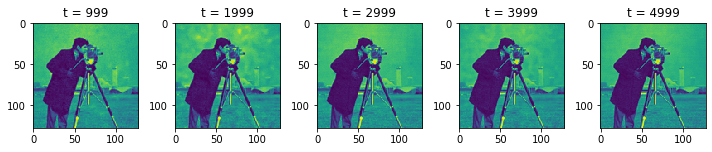

In [12]:
### Signal - CAMERA from skimage
data = skimage.data.camera()
data = Image.fromarray(data)
dim = 128
data = data.resize((dim, dim), Image.ANTIALIAS)
x = (torch.tensor(np.array(data)).double().to(device) / 255)
x = x.reshape(1, dim, dim)
x = x.repeat_interleave(run_parallel, 0) 

nim, nx, ny = x.shape

### Observations
obs = Obs(args_ref=args_ref, args_noise=args_noise,
          oversampling=oversampling, device=device)

x_comp = obs.pad_and_ref(x) 
y = obs.forward(x_comp) 

## Reconstruction
_ = fit(y, obs, niter=niter,
    args_opt=args_opt,
    args_prior=args_prior,
    loss_type=loss_type, 
    x_true=x, 
    verbose_splits=5,
    display=display,
    device=device)

if 'return_model' in args_prior.keys() and args_prior['return_model'] == True:
    losses_y, losses_x, x_splits, x_best, best_dd = _
else:
    losses_y, resds_y, losses_x, x_splits, x_best = _ 

dic = {
        'losses_y': resds_y,
        'resds_y': resds_y,
        'loss_x': losses_x,
        'x_best': x_best,
        'x_splits': x_splits,
        'x_true': x
        }

3/ Visualize results

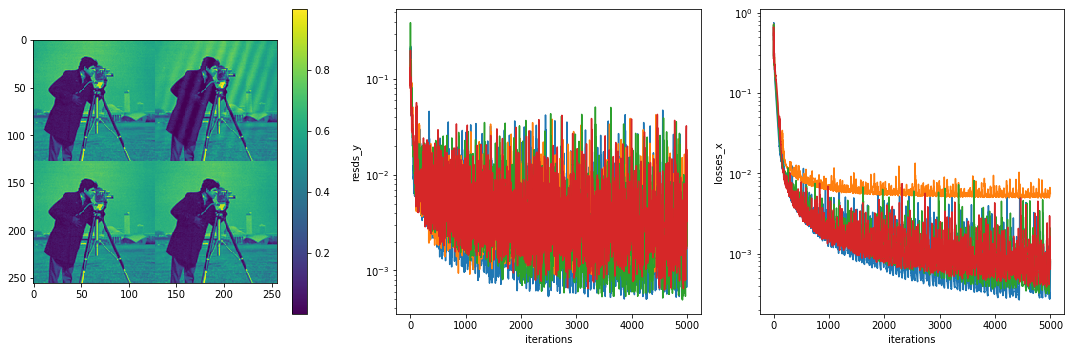

In [13]:
sqrtrp = int(np.sqrt(run_parallel))
plt.figure(figsize=(15,5))

size = dic['x_best'].shape[-1]


x_best_plt = dic['x_best'][:int(sqrtrp**2), ...].reshape(sqrtrp, sqrtrp, size, size).permute(0,2,1,3).reshape(size*sqrtrp, size*sqrtrp)
ax = plt.subplot(131)
im = ax.imshow(x_best_plt.cpu().numpy())
plt.colorbar(im, ax=ax)


ax1 = plt.subplot(132)
ax2 = plt.subplot(133)
for run in range(dic['resds_y'].shape[-1]):
    ax1.plot(dic['resds_y'][:, run])
    ax1.set_yscale('log')
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('resds_y')
    ax2.plot(dic['loss_x'][:, run]/torch.sum(dic['x_true'][run, ...]**2).cpu())
    ax2.set_yscale('log')
    ax2.set_xlabel('iterations')
    ax2.set_ylabel('losses_x')

plt.tight_layout()
plt.show()

In [17]:
obs.ref

True